In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import os
import pandas as pd

# Load the JSON data
file_path = "/home/UNT/ae0589/project/action_engine/eval/scores/dag_scores.json"  # Replace with your file path
with open(file_path, 'r') as file:
    data = json.load(file)

In [2]:
# Extract data into a structured format
records = []
for entry in data:
    timestamp = entry["timestamp"]
    for score in entry["scores"]:
        for method, results in score.items():
            for level, metrics in results["results"].items():
                for metric, values in metrics.items():
                    records.append({
                        "timestamp": timestamp,
                        "method": method,
                        "level": level,
                        "metric": metric,
                        "value": values["value"],
                        "ci_lower": values["confidence_interval"][0],
                        "ci_upper": values["confidence_interval"][1]
                    })

# Convert to DataFrame
df = pd.DataFrame(records)

In [3]:
# Get unique timestamps from the DataFrame
unique_timestamps = df["timestamp"].unique()
# Display unique timestamps
unique_timestamps

array(['2025-01-16 10:29:38', '2025-01-15 19:58:40',
       '2025-01-15 19:56:53', '2025-01-15 19:54:42'], dtype=object)

In [4]:
# Define the mapping of timestamps to labels
timestamp_labels = {
    "2025-01-15 19:58:40": "top-10",
    "2025-01-15 19:56:53": "top-20",
    "2025-01-15 19:54:42": "top-30",
    "2025-01-16 10:29:38": "top-40",
}

# Assign labels to the DataFrame based on the timestamp column
df["label"] = df["timestamp"].map(timestamp_labels)

df.head()

,timestamp,method,level,metric,value,ci_lower,ci_upper,label
0,2025-01-16 10:29:38,FewShot,testdata_level1,AMOUNT,1.000000,1.000000,1.000000,top-40
1,2025-01-16 10:29:38,FewShot,testdata_level1,P_api,0.306977,0.247638,0.375638,top-40
2,2025-01-16 10:29:38,FewShot,testdata_level1,R_api,0.352941,0.288732,0.422517,top-40
3,2025-01-16 10:29:38,FewShot,testdata_level1,F1_api,0.328358,0.268640,0.396948,top-40
4,2025-01-16 10:29:38,FewShot,testdata_level1,P_param,0.169533,0.120475,0.228577,top-40


In [5]:
df_filtered = df[~df["method"].isin(["ZeroShot", "ZeroShot CoT"])]
df_filtered = df_filtered[df_filtered["metric"].isin(["F1_api", "F1_param", "topological_ordering_accuracy"])]
df_filtered.drop(columns=["timestamp"], inplace=True)
df_filtered.drop(columns=["ci_lower", "ci_upper"], inplace=True)

In [6]:
df_filtered

,method,level,metric,value,label
3,FewShot,testdata_level1,F1_api,0.328358,top-40
6,FewShot,testdata_level1,F1_param,0.182781,top-40
7,FewShot,testdata_level1,topological_ordering_accuracy,0.293907,top-40
11,FewShot,testdata_level2,F1_api,0.396887,top-40
14,FewShot,testdata_level2,F1_param,0.211137,top-40
...,...,...,...,...,...
470,Reverse Chain,testdata_level2,F1_param,0.005654,top-30
471,Reverse Chain,testdata_level2,topological_ordering_accuracy,0.005975,top-30
475,Reverse Chain,testdata_level3,F1_api,0.017933,top-30
478,Reverse Chain,testdata_level3,F1_param,0.009600,top-30


/tmp/ipykernel_3031769/1426742533.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_methods)


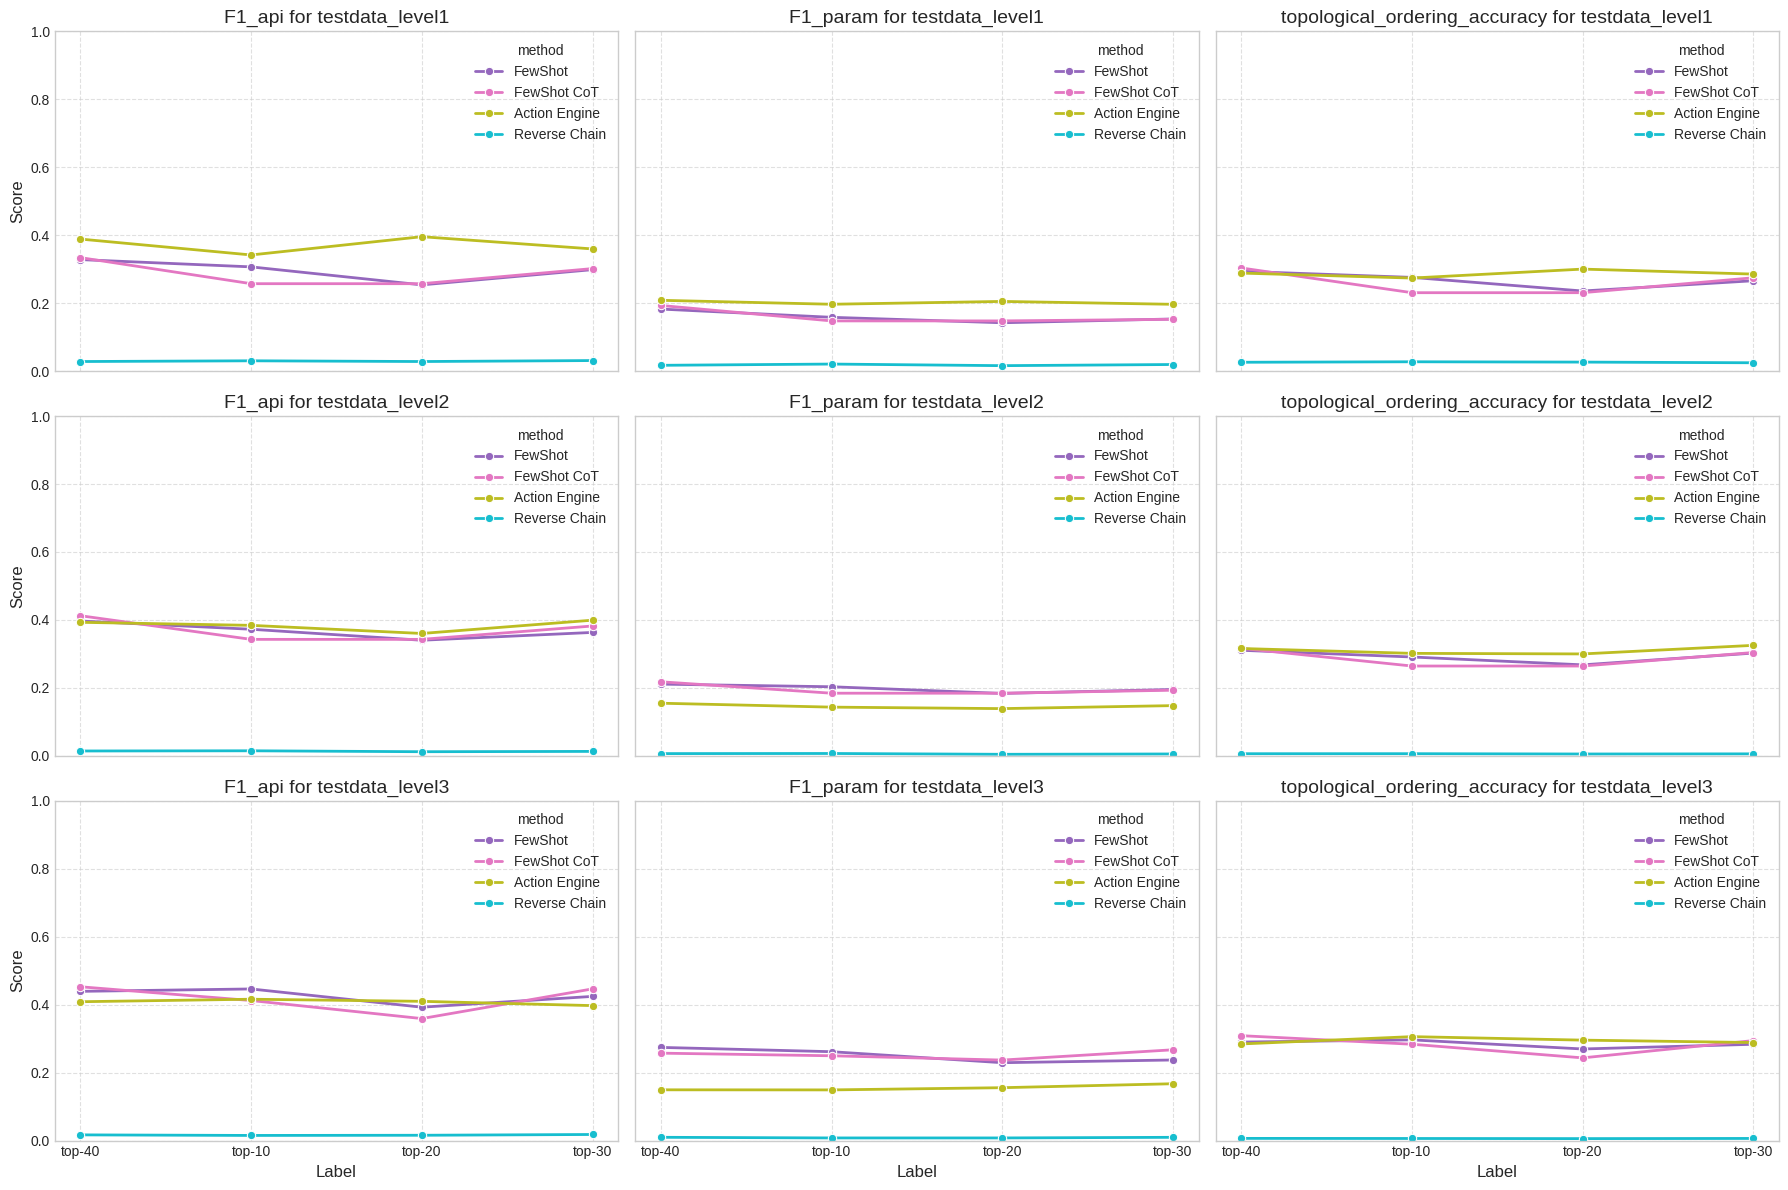

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define figure size and create subplots (3 rows x 3 columns)
fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharex=True, sharey=True)

# Define levels and metrics
levels = ["testdata_level1", "testdata_level2", "testdata_level3"]
metrics = ["F1_api", "F1_param", "topological_ordering_accuracy"]

# Set Seaborn style
plt.style.use("seaborn-v0_8-whitegrid")

# Create a discrete color map for the number of methods
num_methods = 6
colors = plt.cm.get_cmap("tab10", num_methods)

# Define a color mapping for each method
color_mapping = {
    "ZeroShot": colors(0),  
    "ZeroShot CoT": colors(1),  
    "FewShot": colors(2), 
    "FewShot CoT": colors(3),  
    "Action Engine": colors(4),  
    "Reverse Chain": colors(5),  
}

# Loop through levels and metrics to create subplots
for row, level in enumerate(levels):
    for col, metric in enumerate(metrics):
        ax = axes[row, col]
        
        # Filter data for the current level and metric
        subset = df_filtered[(df_filtered["level"] == level) & (df_filtered["metric"] == metric)]
        
        # Plot data with specified colors
        sns.lineplot(
            data=subset, 
            x="label", 
            y="value", 
            hue="method", 
            marker="o", 
            linewidth=2, 
            ax=ax,
            palette=color_mapping  # Apply the custom color mapping
        )
        ax.set_ylim(0, 1)

        # Customize each subplot
        ax.set_title(f"{metric} for {level}", fontsize=14)
        ax.set_xlabel("Label", fontsize=12)
        ax.set_ylabel("Score", fontsize=12)
        ax.grid(True, linestyle="--", alpha=0.6)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

/tmp/ipykernel_3031769/2730535042.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_methods)


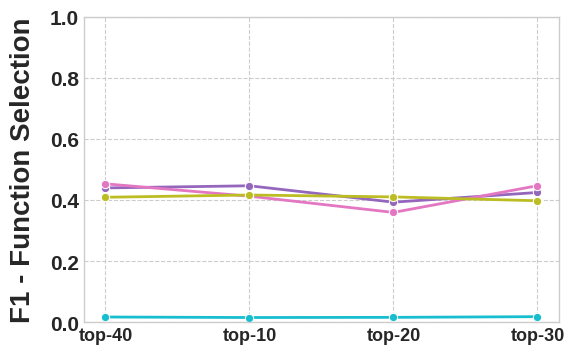

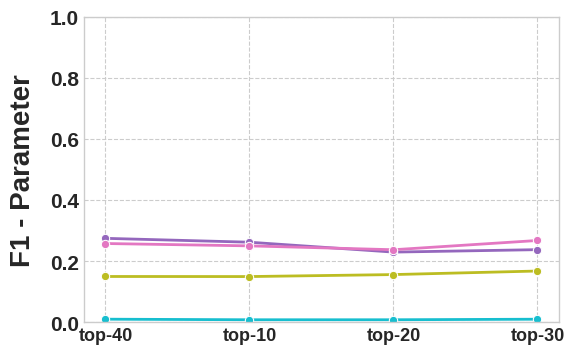

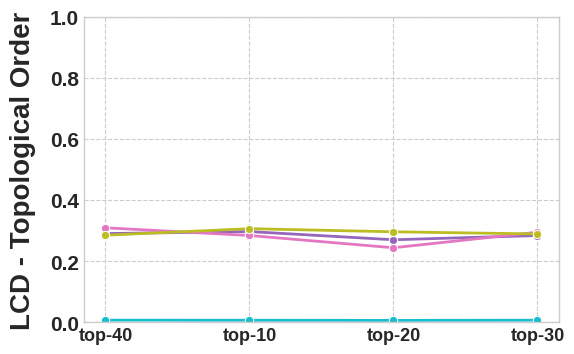

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# Define metrics
metrics = ["F1_api", "F1_param", "topological_ordering_accuracy"]

# Set Seaborn style
plt.style.use("seaborn-v0_8-whitegrid")

# Create a discrete color map for the number of methods
num_methods = 6
colors = plt.cm.get_cmap("tab10", num_methods)

# Define a color mapping for each method
color_mapping = {
    "ZeroShot": colors(0),  
    "ZeroShot CoT": colors(1),  
    "FewShot": colors(2), 
    "FewShot CoT": colors(3),  
    "Action Engine": colors(4),  
    "Reverse Chain": colors(5),  
}

# Adjust global font settings
mpl.rcParams["font.size"] = 15
mpl.rcParams["axes.labelsize"] = 15
mpl.rcParams["axes.titlesize"] = 15
mpl.rcParams["xtick.labelsize"] = 13
mpl.rcParams["ytick.labelsize"] = 15
mpl.rcParams["legend.fontsize"] = 15
mpl.rcParams["font.weight"] = "black"
mpl.rcParams["axes.labelweight"] = "black"
mpl.rcParams["axes.titleweight"] = "black"
metric_mapping = {
    "P_api": "Precision - Function Selection",
    "R_api": "Recall - Function Selection",
    "F1_api": "F1 - Function Selection",
    "P_param": "Precision - Parameter",
    "R_param": "Recall - Parameter",
    "F1_param": "F1 - Parameter",
    "topological_ordering_accuracy": "LCD - Topological Order"
}
# Filter data only for Level 3
level = "testdata_level3"
# Directory to save plots
output_dir = "./eval/plots/params/"
os.makedirs(output_dir, exist_ok=True)
# Create separate plots for each metric
for metric in metrics:
    # Create a new figure for each plot
    plt.figure(figsize=(6, 4))

    # Filter data for the current metric
    subset = df_filtered[(df_filtered["level"] == level) & (df_filtered["metric"] == metric)]

    # Plot data with specified colors
    sns.lineplot(
        data=subset, 
        x="label", 
        y="value", 
        hue="method", 
        marker="o", 
        linewidth=2, 
        palette=color_mapping  # Apply the custom color mapping
    )
    
    # Set y-axis limit
    plt.ylim(0, 1)

    # Customize each plot
    # plt.title(f"{metric}", fontsize=20, weight="bold")
    plt.ylabel(metric_mapping[metric], fontsize=20, labelpad=10, weight='bold')
    plt.xlabel("", fontsize=15, weight="bold")

    # Remove legend if not needed
    plt.legend().remove()  

    # Add grid
    plt.grid(True, linestyle="--")
    # Tight layout and save the plot
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    # Save as PDF
    output_file_pdf = os.path.join(output_dir, f"{metric}.pdf")
    plt.savefig(output_file_pdf, format='pdf', dpi=600)  # High DPI for clear text
    plt.close(fig)
    # Show each plot separately
    plt.show()